# 0.0 - IMPORTS

In [1]:
import math
import json
import pickle
import random
import requests
import datetime
import warnings
import inflection

import numpy       as np
import pandas      as pd
import seaborn     as sns
import xgboost     as xgb

from pandas_profiling        import ProfileReport
from IPython.core.display    import HTML
from IPython.display         import Image
from boruta                  import BorutaPy
from scipy                   import stats           as ss
from matplotlib              import pyplot          as plt
from sklearn                 import model_selection as ms

from sklearn.ensemble        import RandomForestRegressor
from sklearn.linear_model    import LinearRegression, Lasso
from sklearn.preprocessing   import MinMaxScaler, LabelEncoder, RobustScaler
from sklearn.metrics         import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

warnings.filterwarnings( 'ignore' )

C:\Users\perot\anaconda3\envs\rossmann_venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
pd.set_option('display.float_format', lambda x: '%.3f' %x) # Configuração das casas decimais

## 0.1 Helper Functions

In [3]:
def cross_validation(x_training, kfold, model_name, model, verbose=False ):
    mae_list= []
    mape_list = []
    rmse_list = []

    for k in reversed( range(1, kfold+1 ) ):
        if verbose:
            print('\nKFold Number: {}'.format(k) )
       
        # start and end date for validation
        validation_start_date = x_training['date'].max() - datetime.timedelta( days=k*6*7 )
        validadtion_end_date = x_training['date'].max() - datetime.timedelta( days=(k-1)*6*7 )

        # filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validadtion_end_date)]

        # training and validation datasel
        # training
        xtraining = training.drop( ['date','sales'], axis=1 )
        ytraining = training['sales']

        # validation
        xvalidation = validation.drop( ['date','sales'], axis=1 )
        yvalidation = validation['sales']

        # model
        m = model.fit( xtraining, ytraining )

        #prediction
        yhat = m.predict( xvalidation )

        #performance
        m_result = ml_error( model_name, ( yvalidation), (yhat) )

        # store performance of each kfold interation
        mae_list.append( m_result['MAE'] )
        mape_list.append( m_result['MAPE'] )
        rmse_list.append( m_result['RMSE'] )

    return pd.DataFrame( {'Model Name': model_name,
                          'MAE CV': np.round( np.mean( mae_list), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mae_list ), 2 ).astype( str ),
                          'MAPE CV': np.round( np.mean( mape_list), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mape_list ), 2 ).astype( str ),
                          'RMSE CV': np.round( np.mean( rmse_list), 2 ).astype( str ) + ' +/- ' + np.round( np.std( rmse_list ), 2 ).astype( str ) }, index=[0] )

def ml_error( model_name, y, yhat ):
    mae = mean_absolute_error( y, yhat )
    mape = mean_absolute_percentage_error( y, yhat )
    rmse = np.sqrt( mean_squared_error( y, yhat ) )
    
    return pd.DataFrame( {'Model Name': model_name,
                          'MAE': mae,
                          'MAPE': mape,
                          'RMSE': rmse}, index=[0])

def mean_percentage_error ( y, yhat ):
    return np.mean( ( y- yhat ) /y )

def cramer_v( x, y):
    cm = pd.crosstab( x, y).values   
    n = cm.sum()
    r, k = cm.shape    
    
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1) 
    
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )

def data_preparation (df_prep):
    rs = RobustScaler()
    mms = MinMaxScaler()
    le = LabelEncoder()
    
    
# Data Filtering
    df_prep = df_prep[ (df_prep['open'] != 0) & (df_prep['sales'] > 0) ]
    
# Change DTypes
    df_prep['date'] = pd.to_datetime (df_prep['date'] )
       
# Fill NA Values
    # Competition Distance
    df_prep['competition_distance'] = df_prep['competition_distance'].apply( lambda x: 200000.0 if math.isnan( x ) else x )

    # Competition Open Since Month
    df_prep['competition_open_since_month'] = df_prep.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'], axis=1 )

    # Competition Open Since Year
    df_prep['competition_open_since_year'] = df_prep.apply( lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] ) else x['competition_open_since_year'], axis=1 )

    # Promo2 Since Week
    df_prep['promo2_since_week'] = df_prep.apply( lambda x: x['date'].week if math.isnan( x['promo2_since_week'] ) else x['promo2_since_week'], axis=1 )

    # Promo2 Since Year
    df_prep['promo2_since_year'] = df_prep.apply( lambda x: x['date'].year if math.isnan( x['promo2_since_year'] ) else x['promo2_since_year'], axis=1 )

    # Promo Interval
    month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sept', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

    df_prep['promo_interval'].fillna(0, inplace=True)

    df_prep['month_map'] = df_prep['date'].dt.month.map( month_map )

    df_prep['is_promo'] = df_prep[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis=1 )
    

# Change Dtypes after Fill NA
    df_prep['competition_open_since_month'] = df_prep['competition_open_since_month'].astype( int )
    df_prep['competition_open_since_year'] = df_prep['competition_open_since_year'].astype( int )
    df_prep['promo2_since_week'] = df_prep['promo2_since_week'].astype( int )
    df_prep['promo2_since_year'] = df_prep['promo2_since_year'].astype( int )
    
    
# Feature Engineering
    # year
    df_prep['year'] = df_prep['date'].dt.year

    # month
    df_prep['month'] = df_prep['date'].dt.month

    # day
    df_prep['day'] = df_prep['date'].dt.day

    # week of year
    df_prep['week_of_year'] = df_prep['date'].dt.weekofyear

    # year week
    df_prep['year_week'] = df_prep['date'].dt.strftime( '%Y-%W' )

    # competition since
    df_prep['competition_since'] = df_prep.apply( lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1 ), axis=1 )
    df_prep['competition_time_month'] = ( ( df_prep['date'] - df_prep['competition_since'] ) / 30 ).apply( lambda x: x.days ).astype( int )                                                                                      

    # promo since
    df_prep['promo_since'] = df_prep['promo2_since_year'].astype( str ) + '-' + df_prep['promo2_since_week'].astype( str )
    df_prep['promo_since'] = df_prep['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )
    df_prep['promo_time_week'] = ( ( df_prep['date'] - df_prep['promo_since'] ) /7 ).apply( lambda x: x.days ).astype( int )

    # assortment
    df_prep['assortment'] = df_prep['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )

    # state holiday
    df_prep['state_holiday'] = df_prep['state_holiday'].apply( lambda x:'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day' )

    
# Data Filtering
    df_prep = df_prep[ (df_prep['open'] != 0) & (df_prep['sales'] > 0) ]
    cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
    df_prep = df_prep.drop( cols_drop, axis = 1)
    
    
# Reescaling
    # Year
    df_prep['year'] = mms.fit_transform( df_prep[['year']].values )

    # competition distance
    df_prep['competition_distance'] = rs.fit_transform( df_prep[['competition_distance']].values )

    # competition time month
    df_prep['competition_time_month'] = rs.fit_transform( df_prep[['competition_time_month']].values )

    # promo time week
    df_prep['promo_time_week'] = mms.fit_transform( df_prep[['promo_time_week']].values )


# Transformation
    # day of week
    df_prep['day_of_week_sin'] = df_prep['day_of_week'].apply( lambda x: np.sin( x * ( 2. * np.pi/7 ) ) )
    df_prep['day_of_week_cos'] = df_prep['day_of_week'].apply( lambda x: np.sin( x * ( 2. * np.pi/7 ) ) )

    # month
    df_prep['month_sin'] = df_prep['month'].apply( lambda x: np.sin( x * ( 2. * np.pi/12 ) ) )
    df_prep['month_cos'] = df_prep['month'].apply( lambda x: np.sin( x * ( 2. * np.pi/12 ) ) )

    # day
    df_prep['day_sin'] = df_prep['day'].apply( lambda x: np.sin( x * ( 2. * np.pi/30 ) ) )
    df_prep['day_cos'] = df_prep['day'].apply( lambda x: np.sin( x * ( 2. * np.pi/30 ) ) )

    # week of year
    df_prep['week_of_year_sin'] = df_prep['week_of_year'].apply( lambda x: np.sin( x * ( 2. * np.pi/52 ) ) )
    df_prep['week_of_year_cos'] = df_prep['week_of_year'].apply( lambda x: np.sin( x * ( 2. * np.pi/52 ) ) )

    
# Encoder
    # state_holiday - Hot Encoding
    df_prep = pd.get_dummies( df_prep, prefix=['state_holiday'], columns=['state_holiday'] )

    # store_type - Label Encoding
    le = LabelEncoder()
    df_prep['store_type'] = le.fit_transform( df_prep['store_type'] )

    # assortment - Ordinal Encoding
    assortment_dict={'basic':1, 'extra':2, 'extended':3 }
    df_prep['assortment'] = df_prep['assortment'].map( assortment_dict )
    
    # Feature Selection
    cols_selected = ['store', 'promo', 'month_cos', 'month_sin', 'store_type', 'assortment', 'competition_distance', 'competition_open_since_month', 'competition_open_since_year',  'promo2',  'promo2_since_week',
                     'promo2_since_year', 'competition_time_month', 'promo_time_week', 'day_of_week_sin', 'day_of_week_cos', 'week_of_year_cos', 'week_of_year_sin', 'day_sin', 'day_cos', 'sales', 'date']
    
    return( df_prep[cols_selected] )  


def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25,12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container {width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

In [ ]:
jupyter_settings()

## 0.2 Loading Data

In [4]:
df_sales_raw = pd.read_csv( 'C:/Users/perot/Documents/ds_repos/projects/Rossmann_Sales_Prediction/data_csv/train.csv', low_memory= False)
df_store_raw = pd.read_csv( 'C:/Users/perot/Documents/ds_repos/projects/Rossmann_Sales_Prediction/data_csv/store.csv', low_memory= False)

# Merge
df_raw = pd.merge( df_sales_raw, df_store_raw, how='left', on='Store' )

## 0.3 - Rename Colunms

In [5]:
## rename Columns
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 'StoreType',
            'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
            'Promo2SinceWeek','Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore( x )

cols_new = list( map( snakecase, cols_old ) )

# rename
df_raw.columns = cols_new

## 0.4 - SPLIT DATASET INTO TRAINING, TEST AND VALIDATION DATASETS

In [6]:
# Applying train test split to create Train, Validation and Test datasets

X = df_raw.drop( 'sales', axis=1 )
y = df_raw['sales'].copy()
x_train, x_valid, y_train, y_valid = ms.train_test_split( X, y, test_size=0.15 )
x_train, x_test, y_train, y_test = ms.train_test_split( x_train, y_train, test_size=0.15, shuffle=True, random_state=None )

print(f" x_train: {x_train.shape}\n y_train: {y_train.shape}\n x_valid: {x_valid.shape}\n y_valid: {y_valid.shape}\n x_test: {x_test.shape}\n y_test: {y_test.shape}\n")


 x_train: (734932, 17)
 y_train: (734932,)
 x_valid: (152582, 17)
 y_valid: (152582,)
 x_test: (129695, 17)
 y_test: (129695,)



# 1.0 STEP 1 - DATA DESCRIPTION

In [ ]:
df1_train = pd.concat([x_train, y_train], axis=True)

In [ ]:
df1 = df1_train.copy()

## 1.1 Data Dimensions

In [ ]:
print( 'Number of Rows: {}'.format( df1.shape[0] ) )
print( 'Number of Cols: {}'.format( df1.shape[1] ) )

## 1.3 Data Types

In [ ]:
df1['date'] = pd.to_datetime (df1['date'] )

## 1.4 Check NA

In [ ]:
df1.isna().sum()

## 1.5 Fillout NA

In [ ]:
# Competition Distance: to indicate that there is no competitor, a distance of 200.000m will be imputed
df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 200000.0 if math.isnan( x ) else x )

# Competition Open Since Month: to fill this data, were selected the month from the column date, just to not be a NA value.
df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'], axis=1 )

# Competition Open Since Year to fill this data, were selected the year from the column date, just to not be a NA value.
df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] ) else x['competition_open_since_year'], axis=1 )

# Promo2 Since Week to fill this data, were selected the week from the column date, just to not be a NA value.
df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan( x['promo2_since_week'] ) else x['promo2_since_week'], axis=1 )

# Promo2 Since Year to fill this data, were selected the year from the column date, just to not be a NA value.
df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['promo2_since_year'] ) else x['promo2_since_year'], axis=1 )

# Promo Interval
month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sept', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

df1['promo_interval'].fillna(0, inplace=True)

df1['month_map'] = df1['date'].dt.month.map( month_map )

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis=1 )

In [ ]:
df1.isna().sum()

## 1.6 Change Types

In [ ]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( int )
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( int )

df1['promo2_since_week'] = df1['promo2_since_week'].astype( int )
df1['promo2_since_year'] = df1['promo2_since_year'].astype( int )

## 1.7 Descriptive Statistics

In [ ]:
prof = ProfileReport(df1)
prof.to_file(output_file='data_descriptive.html')

### 1.7.1 Numerical Categorics

In [ ]:
num_attributes = df1.select_dtypes( include=['int32', 'int64', 'float64'] )
cat_attributes = df1.select_dtypes( exclude=['int32', 'int64', 'float64', 'datetime64[ns]'] )

In [ ]:
# Central Tendency - mean, median
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( min ) ).T
d3 = pd.DataFrame( num_attributes.apply( max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

# Concatenar
m = pd.concat( [ d2, d3, d4, ct1, ct2, d1, d5, d6 ] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

In [ ]:
sns.displot( df1['competition_distance'] )

### 1.7.2 Categorical Attributes

In [ ]:
cat_attributes.apply( lambda x: x.unique().shape[0] )

In [ ]:
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

plt.subplot(1,3,1)
sns.boxplot( x='state_holiday', y='sales', data=aux1 )

plt.subplot(1,3,2)
sns.boxplot( x='store_type', y='sales', data=aux1 )

plt.subplot(1,3,3)
sns.boxplot( x='assortment', y='sales', data=aux1 )

# 2.0 STEP 2 - FEATURE ENGINEERING

In [ ]:
df2 = df1.copy()

## 2.1 Mapa mental de Hipoteses

In [ ]:
Image('C:/Users/perot/Documents/ds_repos/projects/Rossmann_Sales_Prediction/img/mindmaphypothesis.png')

## 2.2 Hypothesis Creation

### 2.2.1 Hypothesis related to the Store

**1.** Stores with a higher number of employees should sell more.

**2.** Stores with a larger inventory capacity should sell more.

**3.** Larger-sized stores should sell more.

**4.** Stores with a greater variety of products should sell more.

**5.** Stores located closer to competitors should sell less.

**6.** Stores with longer-standing competitors should sell more.

### 2.2.2 Hypothesis related to the Product

**1.** Stores that invest more in marketing should sell more.

**2.** Stores with greater product exposure should sell more.

**3.** Stores with lower-priced products should sell more.

**4.** Stores with more aggressive promotions (larger discounts) should sell more.

**5.** Stores with promotions active for a longer period of time should sell more.

**6.** Stores with more days of promotion should sell more.

**7.** Stores with more consecutive promotions should sell more.

### 2.2.3 Hipoteses Tempo

**1.** Stores open during the Christmas holiday should sell more.

**2.** Stores should sell more over the years.

**3.** Stores should sell more in the second half of the year.

**4.** Stores should sell more after the 10th day of each month.

**5.** Stores should sell less on weekends.

**6.** Stores should sell less during school holidays.

### 2.2.4 Lista Final de Hipoteses

**1.** Stores with a larger variety of products should sell more.

**2.** Stores with closer competitors should sell less.

**3.** Stores with longer-standing competitors should sell more.

**4.** Stores with promotions active for a longer period of time should sell more.

**5.** Stores with more days of promotion should sell more.

**7.** Stores with more consecutive promotions should sell more.

**8.** Stores open during the Christmas holiday should sell more.

**9.** Stores should sell more over the years.

**10.** Stores should sell more in the second half of the year.

**11.** Stores should sell more after the 10th day of each month.

**12.** Stores should sell less on weekends.

**13.** Stores should sell less during school holidays.****

## 2.3 Feature Engineering

In [ ]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.weekofyear

# year week
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

# competition since
df2['competition_since'] = df2.apply( lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1 ), axis=1 )
df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] ) / 30 ).apply( lambda x: x.days ).astype( int )                                                                                      

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )
df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] ) /7 ).apply( lambda x: x.days ).astype( int )

# assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply( lambda x:'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day' )


# 3.0 STEP 3 - FEATURE FILTERING

In [ ]:
df3 = df2.copy()

In [ ]:
df3.head()

## 3.1 Filtragem das Linhas

In [ ]:
df3 = df3[ (df3['open'] != 0) & (df3['sales'] > 0) ]

## 3.2 Seleção das Colunas

In [ ]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop( cols_drop, axis = 1)

In [ ]:
df3.columns

# 4.0 STEP 4 - EXPLORATORY DATA ANALYSIS

In [ ]:
df4 = df3.copy()

## 4.1 Univariate Analysis

### 4.1.1 Response Variable

In [ ]:
sns.distplot(df4['sales'])

### 4.1.2 Numerical Variable

In [ ]:
num_attributes.hist( bins = 25 );

### 4.1.3 Categorical Variable

In [ ]:
df4['state_holiday'].drop_duplicates()

In [ ]:
# state holiday
plt.subplot( 3, 2, 1 )
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot( x=a['state_holiday'] )

plt.subplot( 3, 2, 2 )
sns.kdeplot( df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade=True )
sns.kdeplot( df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True )
sns.kdeplot( df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', shade=True )

# store type
plt.subplot( 3, 2, 3 )
sns.countplot( x=a['store_type'] )

plt.subplot( 3, 2, 4 )
sns.kdeplot( df4[df4['store_type'] == 'a']['sales'], label='a', shade=True )
sns.kdeplot( df4[df4['store_type'] == 'b']['sales'], label='b', shade=True )
sns.kdeplot( df4[df4['store_type'] == 'c']['sales'], label='c', shade=True )
sns.kdeplot( df4[df4['store_type'] == 'd']['sales'], label='d', shade=True )

# assortment
plt.subplot( 3, 2, 5 )
sns.countplot( x=a['assortment'] )

plt.subplot( 3, 2, 6 )
sns.kdeplot( df4[df4['assortment'] == 'extended']['sales'], label='extended', shade=True )
sns.kdeplot( df4[df4['assortment'] == 'basic']['sales'], label='basic', shade=True )
sns.kdeplot( df4[df4['assortment'] == 'extra']['sales'], label='extra', shade=True )

## 4.2 Bivariate Analysis

### H1. Stores with a larger variety of products should sell more.
**False Hypothesis**: Stores with a larger variety of products sell less.

In [ ]:
aux1 = df4[['assortment', 'sales']].groupby( 'assortment' ).sum().reset_index()
sns.barplot( x='assortment', y='sales', data=aux1 );
aux2 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week','assortment'] ).sum().reset_index()
aux2.pivot( index='year_week', columns='assortment', values='sales' ).plot()
aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot( index='year_week', columns='assortment', values='sales' ).plot()

### H2. Stores with closer competitors should sell less.
**False Hypothesis**: Stores with closer competitors sell more.

In [ ]:
aux1 = df4[['competition_distance','sales']].groupby('competition_distance').sum().reset_index()
plt.subplot( 1, 3, 1 )
sns.scatterplot( x='competition_distance', y='sales', data=aux1 )

plt.subplot( 1, 3, 2)
bins = list( np.arange(0, 20000, 1000) )
aux1['competition_distance_binned'] = pd.cut( aux1['competition_distance'], bins=bins )
aux2 = aux1[['competition_distance_binned','sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot( x='competition_distance_binned', y='sales', data=aux2);
plt.xticks( rotation=90 )

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

### H3. Stores with longer-standing competitors should sell more.
**False Hypothesis**: Stores with longer-standing competitors sell less.

In [ ]:
plt.subplot( 1, 3, 1)
aux1 = df4[['competition_time_month','sales']].groupby( 'competition_time_month' ).sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] != 0)]
sns.barplot( x='competition_time_month', y='sales', data=aux2);
plt.xticks( rotation=90 );

plt.subplot( 1, 3, 2)
sns.regplot( x='competition_time_month', y='sales', data=aux2);

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson'), annot=True );

### H4. Stores with promotions active for a longer period of time should sell more.
**False Hypothesis**: Stores with promotions active for a longer period of time sell less after a certain period of time.

In [ ]:
aux1 = df4[['promo_time_week','sales']].groupby('promo_time_week').sum().reset_index()

plt.subplot(2,1,1)
aux2 = aux1[aux1['promo_time_week'] > 0 ] # promo extendida
sns.barplot(x='promo_time_week', y='sales', data=aux2);
plt.xticks( rotation=90 );

plt.subplot(2,1,2)
aux3 = aux1[aux1['promo_time_week'] < 0 ] # promo regular
sns.barplot(x='promo_time_week', y='sales', data=aux3);
plt.xticks( rotation=90 );

###<s>H5. Lojas com mais dias de promoção deveriam vender mais.</s>

### H7. Stores with more consecutive promotions should sell more.
**False Hypothesis**: Stores with consecutive promotions sell less.

In [ ]:
df4[['promo','promo2','sales']].groupby(['promo','promo2']).sum().reset_index()

In [ ]:
aux1 = df4[( df4['promo'] == 1 ) & (df4['promo2'] == 1)][['year_week','sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot()

aux2 = df4[( df4['promo'] == 1 ) & (df4['promo2'] == 0)][['year_week','sales']].groupby('year_week').sum().reset_index()
aux2.plot( ax=ax )

ax.legend(labels=['Tradicional e Extendida','Tradicional'])

### **H8.** Stores open during the Christmas holiday should sell more.
**False Hypothesis**: Stores open during the Christmas holiday sell less.

In [ ]:
plt.subplot(1,2,1)
aux = df4[df4['state_holiday'] != 'regular_day']
aux1 = aux[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
sns.barplot( x='state_holiday', y='sales', data=aux1 );

plt.subplot(1,2,2)
aux2 = aux[['year','state_holiday', 'sales']].groupby( ['year', 'state_holiday'] ).sum().reset_index()
sns.barplot( x='year', y='sales', hue='state_holiday', data=aux2 );

### **H9.** Stores should sell more over the years.
**False Hypothesis**: Store sell less over the years.

In [ ]:
aux1 = df4[['year','sales']].groupby( 'year' ).sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x='year', y='sales', data=aux1);

plt.subplot(1,3,2)
sns.regplot(x='year', y='sales', data=aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr( method='pearson'), annot=True);

### **H10.** Stores should sell more in the second half of the year.
**False Hypothesis:** Stores sell less during the second half of the year.

In [ ]:
aux1 = df4[['month','sales']].groupby( 'month' ).sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x='month', y='sales', data=aux1);

plt.subplot(1,3,2)
sns.regplot(x='month', y='sales', data=aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr( method='pearson'), annot=True);

### **H11.** Stores should sell more after the 10th day of each month.
**True Hypothesis**: Stores sell more after the 10th day of each month.

In [ ]:
aux1 = df4[['day','sales']].groupby( 'day' ).sum().reset_index()

plt.subplot(2,2,1)
sns.barplot(x='day', y='sales', data=aux1);

plt.subplot(2,2,2)
sns.regplot(x='day', y='sales', data=aux1);

plt.subplot(2,2,3)
sns.heatmap(aux1.corr( method='pearson'), annot=True);

aux1['before_after'] = aux1['day'].apply( lambda x: 'before_10_days' if x <= 10 else 'after_10_days' )
aux2 = aux1[['before_after','sales']].groupby( 'before_after' ).sum().reset_index()

plt.subplot(2,2,4)
sns.barplot( x ='before_after', y='sales', data=aux2 )

### **H12.**  Stores should sell less on weekends.
**True Hypothesis**: Stores sell less on weekends.

In [ ]:
aux1 = df4[['day_of_week','sales']].groupby( 'day_of_week' ).sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x='day_of_week', y='sales', data=aux1);

plt.subplot(1,3,2)
sns.regplot(x='day_of_week', y='sales', data=aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr( method='pearson'), annot=True);

### **H13.** Stores should sell less during school holidays.
**True Hypothesis**: Stores sell less during school holidays, except in the months of July and August.

In [ ]:
aux1 = df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()

plt.subplot(2,1,1)
sns.barplot( x='school_holiday', y='sales', data=aux1);

aux2 = df4[['month', 'school_holiday', 'sales']].groupby(['month', 'school_holiday']).sum().reset_index()

plt.subplot(2,1,2)
sns.barplot(x='month', y='sales', hue='school_holiday', data=aux2)

## 4.3 Analise Multivariada

### 4.3.1 Numerical Attributes

In [ ]:
# Only categorical data
a = df4.select_dtypes( include='object')

# Calculate cramer v
a1 = cramer_v( a['state_holiday'], a['state_holiday'] )
a2 = cramer_v( a['state_holiday'], a['store_type'] )
a3 = cramer_v( a['state_holiday'], a['assortment'] )

a4 = cramer_v( a['store_type'], a['state_holiday'] )
a5 = cramer_v( a['store_type'], a['store_type'] )
a6 = cramer_v( a['store_type'], a['assortment'] )

a7 = cramer_v( a['assortment'], a['state_holiday'] )
a8 = cramer_v( a['assortment'], a['store_type'] )
a9 = cramer_v( a['assortment'], a['assortment'] )

# Final DataSet

d = pd.DataFrame( {'state_holiday': [a1, a2, a3],
                   'store_type':    [a4, a5, a6],
                   'assortment':    [a7, a8, a9]  })

d = d.set_index( d.columns )

# Heatmap
sns.heatmap( d, annot=True )

# 5.0 STEP 5 - DATA PREPARATION

In [ ]:
df5 = df4.copy()

## 5.1 - Normalization

## 5.2 - Reescaling

In [ ]:
rs = RobustScaler()
mms = MinMaxScaler()

# Year
df5['year'] = mms.fit_transform( df5[['year']].values )
#pickle.dump( rs, open( 'C:/Users/perot/Documents/ds_repos/projects/Rossmann_Sales_Prediction/rossmann_prediction/parameters/year_scaler.pkl', 'wb') )

# competition distance
df5['competition_distance'] = rs.fit_transform( df5[['competition_distance']].values )
#pickle.dump( rs, open( 'C:/Users/perot/Documents/ds_repos/projects/Rossmann_Sales_Prediction/rossmann_prediction/parameters/competition_distance_scaler.pkl', 'wb') )

# competition time month
df5['competition_time_month'] = rs.fit_transform( df5[['competition_time_month']].values )
#pickle.dump( rs, open( 'C:/Users/perot/Documents/ds_repos/projects/Rossmann_Sales_Prediction/rossmann_prediction/parameters/competition_time_month_scaler.pkl', 'wb') )

# promo time week
df5['promo_time_week'] = mms.fit_transform( df5[['promo_time_week']].values )
#pickle.dump( rs, open( 'C:/Users/perot/Documents/ds_repos/projects/Rossmann_Sales_Prediction/rossmann_prediction/parameters/promo_time_week_scaler.pkl', 'wb') )

## 5.3 - Transformation

In [ ]:
# day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * ( 2. * np.pi/7 ) ) )
df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.sin( x * ( 2. * np.pi/7 ) ) )

# month
df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * ( 2. * np.pi/12 ) ) )
df5['month_cos'] = df5['month'].apply( lambda x: np.sin( x * ( 2. * np.pi/12 ) ) )

# day
df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * ( 2. * np.pi/30 ) ) )
df5['day_cos'] = df5['day'].apply( lambda x: np.sin( x * ( 2. * np.pi/30 ) ) )

# week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * ( 2. * np.pi/52 ) ) )
df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.sin( x * ( 2. * np.pi/52 ) ) )

### 5.3.1 - Encoding

In [ ]:
# state_holiday - Hot Encoding
df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns=['state_holiday'] )

# store_type - Label Encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform( df5['store_type'] )
#pickle.dump(le, open('C:/Users/perot/Documents/ds_repos/projects/Rossmann_Sales_Prediction/rossmann_prediction/parameters/store_type_scaler.pkl', 'wb'))

# assortment - Ordinal Encoding
assortment_dict={'basic':1, 'extra':2, 'extended':3 }
df5['assortment'] = df5['assortment'].map( assortment_dict )

## 5.4 - Aplying Data Preparation on train, test and validation datasets

In [7]:
# Concatenation of features + variable response prior to apply data prepararion on validation and test datasets.
training_df = pd.concat([x_train, y_train], axis=1)
validation_df = pd.concat([x_valid, y_valid], axis=1)
test_df = pd.concat([x_test, y_test], axis=1)

In [8]:
# Applying data preparation on validation and test datasets
x_train_prep = data_preparation(training_df)
x_valid_prep = data_preparation(validation_df)
x_test_prep = data_preparation(test_df)

### 5.4.1 - Creation of Training, Validation and Test dataset

In [9]:
X_train = x_train_prep.drop('sales', axis=1)
Y_train = x_train_prep['sales']
X_valid = x_valid_prep.drop('sales', axis=1)
Y_valid = x_valid_prep['sales']
X_test = x_test_prep.drop('sales', axis=1)
Y_test = x_test_prep['sales']

In [10]:
print(f" X_train:{X_train.shape}\n Y_train:{Y_train.shape}\n X_valid:{X_valid.shape}\n Y_valid:{Y_valid.shape}\n X_test{X_test.shape}\n Y_test{Y_test.shape}")

 X_train:(610017, 21)
 Y_train:(610017,)
 X_valid:(126637, 21)
 Y_valid:(126637,)
 X_test(107684, 21)
 Y_test(107684,)


# 6.0 STEP 6 - FEATURE SELECTION

In [ ]:
# Creation of Datasets for Feature Selection

In [ ]:
x_train_fs = X_train.drop('date', axis=1).copy()
y_train_fs = Y_train.copy()

## 6.2 - Boruta as Feature Selector

In [ ]:
# training and test dataset for Boruta
x_train_n = x_train_fs.values
y_train_n = y_train_fs.values.ravel()

# Define RandomForest Regressor
rf = RandomForestRegressor( n_jobs=-1 )

#  Define Boruta
boruta = BorutaPy( rf, n_estimators='auto', verbose=2, random_state=42 ).fit( x_train_n, y_train_n )

### 6.2.1 - Best features from Boruta

In [ ]:
cols_selected = boruta.support_.tolist()

# Best Features
cols_selected_boruta = x_train_fs.iloc[:, cols_selected].columns.to_list()

cols_not_selected_boruta = list(np.setdiff1d(x_train_fs.columns, cols_selected_boruta ) )

In [ ]:
cols_selected_boruta

In [ ]:
cols_not_selected_boruta

## 6.3 - Manual Feature Selection

In [11]:
cols_selected_boruta = [
 'store',
 'promo',
 'month_cos',
 'month_sin',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'day_of_week_sin',
 'day_of_week_cos',
 'week_of_year_cos',
 'week_of_year_sin',   
 'day_sin',
 'day_cos']

# 7.0 STEP 7 - ML MODEL'S

In [ ]:
# Dataset to be used for ML Cross-Validation training

In [12]:
df_cv = df_raw.copy()

In [13]:
training_cv = data_preparation(df_cv)

In [14]:
training_cv.shape

(844338, 22)

In [15]:
# Dataset to be used for ML regular training and Fine Tuning

In [16]:
X_train_reg = X_train.drop('date', axis=1).copy()
X_test_reg = X_test.drop('date', axis=1).copy()
X_valid_reg = X_valid.drop('date', axis=1).copy()

In [17]:
X_train_reg.head()

,store,promo,month_cos,month_sin,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,competition_time_month,promo_time_week,day_of_week_sin,day_of_week_cos,week_of_year_cos,week_of_year_sin,day_sin,day_cos
812528,479,1,-0.500,-0.500,0,1,-0.324,12,2005,1,9,2011,1.014,0.567,0.434,0.434,-0.121,-0.121,0.588,0.588
505542,118,1,0.866,0.866,3,3,0.202,9,2012,0,14,2014,0.027,0.287,-0.975,-0.975,0.993,0.993,0.743,0.743
183327,468,1,0.866,0.866,2,3,0.473,9,2012,0,8,2015,0.162,0.287,0.975,0.975,0.823,0.823,-0.407,-0.407
997215,76,0,0.500,0.500,3,3,2.844,3,2006,0,3,2013,0.892,0.287,-0.975,-0.975,0.355,0.355,-0.588,-0.588
561073,1014,0,0.866,0.866,0,3,-0.342,2,2014,1,31,2013,-0.230,0.351,-0.975,-0.975,0.749,0.749,0.208,0.208


## 7.1 - Average Model

In [ ]:
aux1 = pd.concat([X_valid, Y_valid], axis=1)

# Predictions
aux2 = aux1[['store', 'sales']].groupby('store').mean().reset_index().rename( columns={'sales': 'predictions'} )
aux1 = pd.merge( aux1, aux2, how='left', on='store' )
yhat_baseline= aux1['predictions']

# Performance
baseline_result = ml_error( 'Average Model', ( Y_valid ), ( yhat_baseline ) )
baseline_result

## 7.2 - Linear Regression Model

In [ ]:
# model
lr = LinearRegression().fit( X_train_reg, Y_train )

# prediction
yhat_lr = lr.predict( X_valid_reg )

# performance
lr_result = ml_error( 'Linear Regression', ( Y_valid ), ( yhat_lr ) )
lr_result

### 7.2.1 - Linear Regression Model: Cross Validation

In [ ]:
lr_result_cv = cross_validation( training_cv, 5, 'Linear Regression', lr, verbose=False )
lr_result_cv

## 7.3 - Linear Regression Regularized Model

In [ ]:
# model
lrr = Lasso( alpha=0.01 ).fit( X_train_reg, Y_train )

# prediction
yhat_lrr = lrr.predict( X_valid_reg )

# performance
lrr_result = ml_error( 'Linear Regression - Lasso', ( Y_valid ), ( yhat_lrr ) )
lrr_result

### 7.3.1 - Linear Regression Regularized Model - Cross Validation

In [ ]:
lrr_result_cv = cross_validation( training_cv , 5, 'Lasso', lrr, verbose=False )
lrr_result_cv

## 7.4 - Random Forest Regressor

In [ ]:
# model definition
rf = RandomForestRegressor( n_estimators=100, n_jobs=-1, random_state=42 ).fit( X_train_reg, Y_train )

# prediction
yhat_rf = rf.predict( X_valid_reg )

# performance
rf_result = ml_error( 'Random Forest Regressor', ( Y_valid ), ( yhat_rf ) )
rf_result

### 7.4.1 - Randon Forest Regresson - Cross Validation

In [ ]:
rf_result_cv = cross_validation( training_cv, 5, 'Randon Forest Regressor', rf, verbose=True )
rf_result_cv

## 7.5 - XGBoost Regressor

In [ ]:
# model
model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
                              n_estimators=100,
                              eta=0.01,
                              max_depth=10,
                              subsample=0.7,
                              colsample_bytree=0.9 ).fit( X_train_reg, Y_train )                      

# prediction
yhat_xgb = model_xgb.predict( X_valid_reg)

# performance
xgb_result = ml_error( 'XGBoost Regressor', ( Y_valid ), ( yhat_xgb ) )
xgb_result

### 7.5.1 - XGBoost Regressor - Cross Validation

In [ ]:
xgb_result_cv = cross_validation( training_cv, 5, 'XGboost Regressor', model_xgb, verbose=True )
xgb_result_cv

## 7.6 - Compare Model's Performance

### 7.6.1 - Single Performance

In [ ]:
modelling_result = pd.concat( [baseline_result, lr_result, lrr_result, rf_result, xgb_result] )
modelling_result.sort_values( 'RMSE' )

### 7.6.2 - Real Performance: Cross Validation

In [ ]:
modelling_result_cv = pd.concat( [lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv] )
modelling_result_cv.sort_values('RMSE CV')

# 8.0 STEP 8 - HYPERPARAMETER FINE TUNING

## 8.1 - Random Search

In [18]:
param = {
     'n_estimators': [100,350,550,850,1000], 
     'eta': [0.01, 0.03],
     'max_depth': [5, 9, 13, 17, 20],
     'subsample': [0.1, 0.5, 0.7],
     'colsample_bytree': [0.3, 0.7, 0.9],
     'min_child_weight':[3, 8, 15] }

MAX_EVAL = 5

In [ ]:
final_result = pd.DataFrame()

for i in range( MAX_EVAL ):
    # choose values for parameters randomly
    hp = { k: random.sample(v, 1)[0] for k, v in param.items() }
    print( hp )
    
    # model
    model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
                                  n_estimators=hp['n_estimators'],
                                  eta=hp['eta'],
                                  max_depth=hp['max_depth'],
                                  subsample=hp['subsample'],
                                  colsample_bytree=hp['colsample_bytree'],
                                  min_child_weight=hp['min_child_weight'] )

    # performance
    result = cross_validation( training_cv, 5, 'XGBoost Regressor', model_xgb, verbose=True )
    final_result = pd.concat( [final_result, result] )

final_result

## 8.2 - Final Model

In [19]:
param_tuned = {
    'n_estimators':100, 
    'eta':0.03,
    'max_depth':9,
    'subsample':0.1,
    'colsample_bytree':0.3,
    'min_child_weight':3}

In [20]:
aux1 = pd.concat([X_train_reg, Y_train], axis=1)
aux2 = pd.concat([X_valid_reg, Y_valid], axis=1)
training_final = pd.concat([aux1, aux2], axis=0)
x_training_final = training_final.drop('sales', axis=1)
y_trianing_final = training_final['sales']

In [24]:
# Model Definition
model_xgb_tuned = xgb.XGBRegressor( objective='reg:squarederror',
                                    n_estimators=param_tuned['n_estimators'],
                                    eta=param_tuned['eta'],
                                    max_depth=param_tuned['max_depth'],
                                    subsample=param_tuned['subsample'],
                                    colsample_bytree=param_tuned['colsample_bytree'],
                                    min_child_weight=param_tuned['min_child_weight'] )
# Model Training
model_xgb_tuned.fit(x_training_final, y_trianing_final)

# prediction
yhat_xgb_tuned = model_xgb_tuned.predict( X_test_reg )

# performance           
xgb_result_tuned = ml_error( 'XGBoost Regressor', ( Y_test), ( yhat_xgb_tuned ) )
xgb_result_tuned

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,1567.704,0.248,2216.028


In [25]:
mpe = mean_percentage_error( (Y_test), (yhat_xgb_tuned) )
mpe

-0.06626192782901419

# 9.0 STEP 9 - EVALUATION

In [33]:
df9 = x_test_prep.copy()

# rescale
df9['sales'] = ( df9['sales'] )
df9['predictions'] = ( yhat_xgb_tuned )

## 9.1 - Business Performance

In [34]:
# sum of predictions
df91 = df9[['store', 'predictions']].groupby( 'store' ).sum().reset_index()

# MAE and MAPE
df9_aux1 = df9[['store','sales','predictions']].groupby( 'store' ).apply( lambda x: mean_absolute_error( x['sales'], x['predictions'] ) ).reset_index().rename( columns={0:'MAE'} )
df9_aux2 = df9[['store','sales','predictions']].groupby( 'store' ).apply( lambda x: mean_absolute_percentage_error( x['sales'], x['predictions'] ) ).reset_index().rename( columns={0:'MAPE'} )

# Merge
df9_aux3 = pd.merge( df9_aux1, df9_aux2, how='inner', on='store')
df92 = pd.merge( df91, df9_aux3, how='inner', on='store')

# Scenarios
df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario'] = df92['predictions'] + df92['MAE']

# order columns
df92 = df92[['store','predictions','worst_scenario','best_scenario','MAE','MAPE']]

In [35]:
df92.head()

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
0,1,675963.688,674778.571,677148.804,1185.117,0.271
1,2,598894.250,598073.587,599714.913,820.663,0.206
2,3,639667.125,638589.446,640744.804,1077.679,0.149
3,4,717799.812,716013.112,719586.513,1786.701,0.179
4,5,426546.562,425930.064,427163.061,616.498,0.174


In [36]:
df92.sort_values( 'MAPE', ascending=False).head()

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
542,543,679551.875,676313.015,682790.735,3238.860,1.496
197,198,511493.062,509313.427,513672.698,2179.635,1.312
702,703,687870.625,684242.949,691498.301,3627.676,1.213
207,208,572005.938,568612.005,575399.870,3393.933,1.212
424,425,625826.312,622245.581,629407.044,3580.732,1.212


<AxesSubplot: xlabel='store', ylabel='MAPE'>

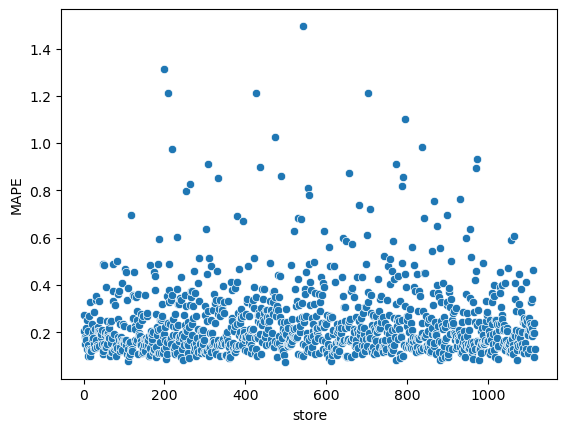

In [37]:
sns.scatterplot( x='store', y='MAPE', data=df92)

## 9.2 - Total Performance

In [38]:
df93 = df92[['predictions','worst_scenario','best_scenario']].apply( lambda x: np.sum( x ), axis=0 ).reset_index().rename( columns={'index': 'Scenario', 0: 'Values'})

df93['Values'] = df93['Values'].map( 'R${:,.2f}'.format )
df93

,Scenario,Values
0,predictions,"R$711,366,400.00"
1,worst_scenario,"R$709,624,574.32"
2,best_scenario,"R$713,108,272.62"


## 9.3 - ML Performance

In [39]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

TypeError: scatterplot() takes from 0 to 1 positional arguments but 2 were given

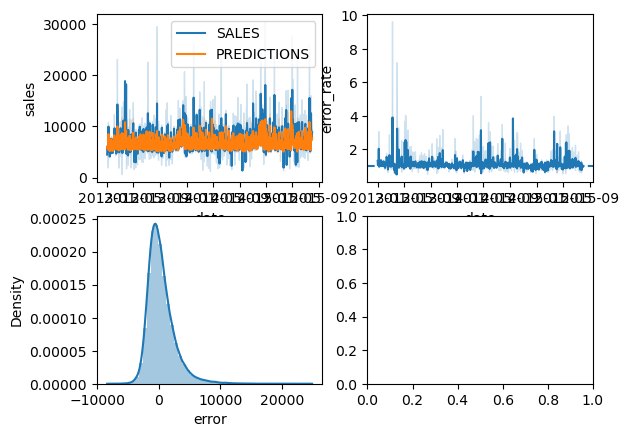

In [40]:
plt.subplot( 2, 2, 1 )
sns.lineplot( x='date', y='sales', data=df9, label='SALES')
sns.lineplot( x='date', y='predictions', data=df9, label='PREDICTIONS')

plt.subplot( 2, 2, 2 )
sns.lineplot( x='date', y='error_rate', data=df9)
plt.axhline(1, linestyle='--')

plt.subplot( 2, 2, 3 )
sns.distplot( df9['error'] )

plt.subplot( 2, 2, 4 )
sns.scatterplot( df9['predictions'], df9['error'] )

# 10.0 STEP 10 - DEPLOY MODEL TO PRODUCTION

## 10.1 - Rossmann Class

In [ ]:
import math
import json
import pickle
import datetime
import inflection
import pandas   as pd
import numpy    as np

class Rossmann( object ):
    def __init__( self ):
        self.home_path                     = 'C:/Users/perot/Documents/ds_repos/projects/Rossmann_Sales_Prediction/rossmann_prediction'
        self.competition_time_month_scaler = pickle.load( open( self.home_path + '/parameters/competition_time_month_scaler.pkl', 'rb') )
        self.competition_distance_scaler   = pickle.load( open( self.home_path + '/parameters/competition_distance_scaler.pkl', 'rb') )
        self.promo_time_week_scaler        = pickle.load( open( self.home_path + '/parameters/promo_time_week_scaler.pkl', 'rb') )
        self.store_type_scaler             = pickle.load( open( self.home_path + '/parameters/store_type_scaler.pkl', 'rb'))
        self.year_scaler                   = pickle.load( open( self.home_path + '/parameters/year_scaler.pkl', 'rb') )
              
    def data_cleaning( self, df1 ):
 
        ## rename Columns
        cols_old = ['Store', 'DayOfWeek', 'Date', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 'StoreType',
                        'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
                        'Promo2SinceWeek','Promo2SinceYear', 'PromoInterval']

        snakecase = lambda x: inflection.underscore( x )

        cols_new = list( map( snakecase, cols_old ) )

        # rename
        df1.columns = cols_new

        # data types
        df1['date'] = pd.to_datetime (df1['date'] )

        # fillout NA

        # Competition Distance
        df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 200000.0 if math.isnan( x ) else x )

        # Competition Open Since Month
        df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'], axis=1 )

        # Competition Open Since Year
        df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] ) else x['competition_open_since_year'], axis=1 )

        # Promo2 Since Week
        df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan( x['promo2_since_week'] ) else x['promo2_since_week'], axis=1 )

        # Promo2 Since Year
        df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['promo2_since_year'] ) else x['promo2_since_year'], axis=1 )

        # Promo Interval
        month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sept', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

        df1['promo_interval'].fillna(0, inplace=True)

        df1['month_map'] = df1['date'].dt.month.map( month_map )

        df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis=1 )

        # change data types

        # competition
        df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( int )
        df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( int )

        # promo2
        df1['promo2_since_week'] = df1['promo2_since_week'].astype( int )
        df1['promo2_since_year'] = df1['promo2_since_year'].astype( int )

        return df1
    
    def feature_engineering( self, df2 ):
        
        # year
        df2['year'] = df2['date'].dt.year

        # month
        df2['month'] = df2['date'].dt.month

        # day
        df2['day'] = df2['date'].dt.day

        # week of year
        df2['week_of_year'] = df2['date'].dt.weekofyear

        # year week
        df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

        # competition since
        df2['competition_since'] = df2.apply( lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1 ), axis=1 )
        df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] ) / 30 ).apply( lambda x: x.days ).astype( int )                                                                                      

        # promo since
        df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
        df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )
        df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] ) /7 ).apply( lambda x: x.days ).astype( int )

        # assortment
        df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )

        # state holiday
        df2['state_holiday'] = df2['state_holiday'].apply( lambda x:'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day' )    

        # rows filtering
        df2 = df2[df2['open'] != 0]

        # cols selection
        cols_drop = ['open', 'promo_interval', 'month_map']
        df2 = df2.drop( cols_drop, axis = 1)

        return df2

    def data_preparation( self, df5 ):

        # 5.2 - Rescaling

        # competition distance
        df5['competition_distance'] = self.competition_distance_scaler.transform( df5[['competition_distance']].values )

        # Year
        df5['year'] = self.year_scaler.transform( df5[['year']].values )

        # competition time month
        df5['competition_time_month'] = self.competition_time_month_scaler.transform( df5[['competition_time_month']].values )

        # promo time week
        df5['promo_time_week'] = self.promo_time_week_scaler.transform( df5[['promo_time_week']].values )

        ### 5.3.1 - Encoding
        
        # state_holiday - Hot Encoding
        df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns=['state_holiday'] )

        # store_type - Label Encoding
        df5['store_type'] = self.store_type_scaler.fit_transform( df5['store_type'] )
        
        # assortment - Ordinal Encoding
        assortment_dict={'basic':1, 'extra':2, 'extended':3 }
        df5['assortment'] = df5['assortment'].map( assortment_dict )

        ### 5.3.3 - Encoding

        # day of week
        df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * ( 2. * np.pi/7 ) ) )
        df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.sin( x * ( 2. * np.pi/7 ) ) )

        # month
        df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * ( 2. * np.pi/12 ) ) )
        df5['month_cos'] = df5['month'].apply( lambda x: np.sin( x * ( 2. * np.pi/12 ) ) )

        # day
        df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * ( 2. * np.pi/30 ) ) )
        df5['day_cos'] = df5['day'].apply( lambda x: np.sin( x * ( 2. * np.pi/30 ) ) )

        # week of year
        df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * ( 2. * np.pi/52 ) ) )
        df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.sin( x * ( 2. * np.pi/52 ) ) )
        
        cols_selected = ['store', 'promo', 'month_cos', 'month_sin', 'store_type', 'assortment', 'competition_distance', 'competition_open_since_month', 'competition_open_since_year', 'promo2', 'promo2_since_week',
                         'promo2_since_year', 'competition_time_month', 'promo_time_week', 'day_of_week_sin', 'day_of_week_cos', 'week_of_year_cos', 'week_of_year_sin', 'day_sin', 'day_cos']
        
        return df5[ cols_selected ]
    
    def get_prediction (self, model, original_data, test_data ):
        # prediction
        pred = model.predict( test_data )
        
        # join pred into the original data
        original_data['prediction'] = np.expm1( pred )
        
        return original_data.to_json( orient='records', date_format='iso' )

## 10.2 - API Handler

In [ ]:
import pickle

import pandas as pd

from flask             import Flask, request, Response
from rossmann.rossmann import Rossmann

# loading model

model = pickle.load( open( 'C:/Users/perot/Documents/ds_repos/projects/Rossmann_Sales_Prediction/rossmann_prediction/model/model_rossmann.pkl', 'rb' ) )

# initialize API
app = Flask( __name__ )

@app.route( '/rossmann/predict', methods=['POST'] )

def rossmann_predict():
    test_json = request.get_json()
    
    if test_json: #there is data
               
        if isinstance( test_json, dict ): # unique example
            test_raw = pd.DataFrame( test_json, index=[0] )
    
        else:
            test_raw = pd.DataFrame( test_json, columns=test_json[0].keys() ) # multiple examples
            
        # Instantiate Rossmann Class
        pipeline = Rossmann()
        
        # data cleaning
        df1 = pipeline.data_cleaning( test_raw )
        
        # feature engineering
        df2 = pipeline.feature_engeneering( df1 )
                
        # data preparation
        df3 = pipeline.data_preparation( df2 )
                
        # prediction
        df_response = pipeline.get_prediction( model, test_raw, df3 )
        
        return df_response
        
    else:
        return Response( '{}', status=200, mimetype='application/json' )

if __name__ == '__main__':
    app.run( '0.0.0.0' )

## 10.3 - API Tester

In [ ]:
# Loading test dataset
df10 = pd.read_csv( 'C:/Users/perot/Documents/ds_repos/projects/Rossmann_Sales_Prediction/data_csv/test.csv' )

In [ ]:
# merge test dataset + store
df_test = pd.merge( df10, df_store_raw, how='left', on='Store' )

# choose store for prediction
df_test = df_test[df_test['Store'] == 22]

# remove closed days
df_test = df_test[df_test['Open'] != 0]
df_test = df_test[~df_test['Open'].isnull() ]
df_test = df_test.drop( 'Id', axis=1 )

In [ ]:
# convert dataframe to json
data = json.dumps( df_test.to_dict( orient='records' ) )

In [ ]:
# API Call
url = 'https://rossmann-api-1osh.onrender.com/rossmann/predict'
header = {'Content-type': 'application/json'}
data = data

r = requests.post( url, data=data , headers=header )
print( 'Stadus Code{}'.format( r.status_code ) )

In [ ]:
d1 = pd.DataFrame( r.json(), columns=r.json()[0].keys() )

In [ ]:
d2 = d1[['store','prediction']].groupby( 'store' ).sum().reset_index()

for i in range( len( d2 ) ):
    print( 'Store number {} will sell R${:,.2f} in the next six weeks.'.format(d2.loc[i, 'store'], d2.loc[i, 'prediction'] ) )

In [ ]:
d1.head()